In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import akita_utils_forplotting as utils
import numpy as np
import pandas as pd
import sys, os, psutil, time 
import matplotlib.pyplot as plt
import pysam
    
from skimage.transform import resize


#from optparse import OptionParser


nt = ['A', 'T', 'C', 'G']

2023-11-09 15:54:55.718470: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-09 15:54:55.718504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-11-09 15:54:57.890655: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-11-09 15:54:57.890687: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-11-09 15:54:57.890716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ruby.gladstone.internal): /proc/driver/nvidia/version does not exist
2023-11-09 15:54:57.890912: I tensorflow/core/platfor

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 sequence (InputLayer)          [(None, 1048576, 4)  0           []                               
                                ]                                                                 
                                                                                                  
 stochastic_reverse_complement   ((None, 1048576, 4)  0          ['sequence[0][0]']               
 (StochasticReverseComplement)  , ())                                                             
                                                                                                  
 stochastic_shift (StochasticSh  (None, 1048576, 4)  0           ['stochastic_reverse_complement[0
 ift)                                                            ][0]']                     

                                                                                                  
 re_lu_8 (ReLU)                 (None, 4096, 96)     0           ['max_pooling1d_7[0][0]']        
                                                                                                  
 conv1d_8 (Conv1D)              (None, 4096, 96)     46080       ['re_lu_8[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 4096, 96)    384         ['conv1d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 max_pooling1d_8 (MaxPooling1D)  (None, 2048, 96)    0           ['batch_normalization_8[0][0]']  
                                                                                                  
 re_lu_9 (

 add_2 (Add)                    (None, 512, 96)      0           ['add_1[0][0]',                  
                                                                  'dropout_2[0][0]']              
                                                                                                  
 re_lu_17 (ReLU)                (None, 512, 96)      0           ['add_2[0][0]']                  
                                                                                                  
 conv1d_17 (Conv1D)             (None, 512, 48)      13824       ['re_lu_17[0][0]']               
                                                                                                  
 batch_normalization_17 (BatchN  (None, 512, 48)     192         ['conv1d_17[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_18 

 batch_normalization_25 (BatchN  (None, 512, 48)     192         ['conv1d_25[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 re_lu_26 (ReLU)                (None, 512, 48)      0           ['batch_normalization_25[0][0]'] 
                                                                                                  
 conv1d_26 (Conv1D)             (None, 512, 96)      4608        ['re_lu_26[0][0]']               
                                                                                                  
 batch_normalization_26 (BatchN  (None, 512, 96)     384         ['conv1d_26[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 dropout_7

                                                                                                  
 batch_normalization_32 (BatchN  (None, 512, 512, 48  192        ['conv2d_4[0][0]']               
 ormalization)                  )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 512, 512, 48  0           ['batch_normalization_32[0][0]'] 
                                )                                                                 
                                                                                                  
 add_9 (Add)                    (None, 512, 512, 48  0           ['symmetrize2d_1[0][0]',         
                                )                                 'dropout_9[0][0]']              
                                                                                                  
 symmetriz

 ormalization)                  )                                                                 
                                                                                                  
 dropout_12 (Dropout)           (None, 512, 512, 48  0           ['batch_normalization_38[0][0]'] 
                                )                                                                 
                                                                                                  
 add_12 (Add)                   (None, 512, 512, 48  0           ['symmetrize2d_4[0][0]',         
                                )                                 'dropout_12[0][0]']             
                                                                                                  
 symmetrize2d_5 (Symmetrize2D)  (None, 512, 512, 48  0           ['add_12[0][0]']                 
                                )                                                                 
          

In [3]:
#TOTAL AKITA INPUT LENGTH 

akita_seq_len=1048576


#HG38 REF FA
hg38_file = '/pollard/home/shzhang/akita/run_akita/refs/hg38.fa'
fasta_hg38 = pysam.Fastafile(hg38_file)

#GENCODE
gene_annot = pd.read_csv('/pollard/data/genetics/GENCODE/release32/gencode.v32.genes_only.bed', sep = '\t', names = ['CHROM', 'start_gene', 'end_gene', 'Gene'])
gene_annot[gene_annot.CHROM != 'chrM']
gene_annot.head()

,CHROM,start_gene,end_gene,Gene
0,chr1,11869,14409,DDX11L1
1,chr1,14404,29570,WASH7P
2,chr1,17369,17436,MIR6859-1
3,chr1,29554,31109,MIR1302-2HG
4,chr1,30366,30503,MIR1302-2


In [4]:
#read in a small matrix as a check 
#data directories
date = '20230726'
d='/pollard/home/shzhang/akita_variant_scoring/akdemir_collab/'
data_dir = d + 'data/'
fig_dir = d + 'figs/' + date + '/'

#two folders are colab_fasta and new_fasta

In [5]:
files=os.listdir(data_dir+'new_fasta/walks.fasta/')

In [6]:
#akita plotting functions
def read_fasta(fa):
    '''
    read in fasta file and return sequence only 
    '''   
    seq=''
    with open(fa, "r") as fa_file:
        for line in fa_file:
            if not (line.startswith('>')):
                seq += line.strip()
    fa_file.close()               
    return(seq)   

def mat_from_vector(pred_targets):
    mat = from_upper_triu(pred_targets,seq_len_pool,2)
    #mat = interp_all_nans(mat) 
    return mat

def from_upper_triu(vector_repr, matrix_len, num_diags):
    z = np.zeros((matrix_len,matrix_len))
    triu_tup = np.triu_indices(matrix_len,num_diags)
    z[triu_tup] = vector_repr
    for i in range(-num_diags+1,num_diags):
        set_diag(z, np.nan, i)
    return z + z.T

In [7]:
def make_akita_pred_complex(i):
    print(i)
    bed_name=i[:-3] +'.bed'
    name_parts = i.rsplit('_', 2)

    gencode_coord=gene_annot[gene_annot.Gene == name_parts[1]]    
    gene_len=abs(gencode_coord.end_gene-gencode_coord.start_gene)
    gene_mid_coord=np.floor(gencode_coord.start_gene + (gene_len/2))
    #print('gene mid coord', gene_mid_coord)
    #print('gencode coord', gencode_coord)
    
    #read in bed file and figure out where to center the file 
    bed=pd.read_csv(data_dir+ 'new_fasta/walks.bed/' + bed_name, sep='\t', header=None)
    #rename columns
    bed.columns = ['chr', 'start', 'end', 'strand', '4', '5']
    bed['chr'] = bed['chr'].astype('str') 
    #get spans of each walk 
    bed['span']=abs(bed['end']-bed['start']) 
    #print(bed)
    
    #print('bed span', np.sum(bed['span']))


    #get the row where gene_mid_coord 
    #print(gencode_coord['CHROM'])
    condition = ((bed['chr']==gencode_coord.CHROM.values[0])
                & (bed['start'] <= int(gene_mid_coord)) & (int(gene_mid_coord) <= bed['end']) ) 

    #pd.set_option('display.max_rows', None)
    #print('condition', condition.index[condition])
    #in cases where the middle of the gene shows up more than once, just takes first instance 
    row_midgene = (condition.index[condition].tolist())[0]

    #print('row_midgene index', row_midgene)
        
        

    #get span for the entire walk up to the middle of the gene 
    bed_row=bed.iloc[row_midgene, :]
    #print('bed_Row', bed_row)
    #print('gene row span', np.sum(bed_row['span']))
    #print('gene_mid_Coord', gene_mid_coord)
    if row_midgene>0:
        bed_begin=bed.iloc[0:row_midgene, :]
        #print('bed_begin', bed_begin)
        first_half_span=(np.sum(bed_begin['span'])) + int(gene_mid_coord-bed_row['start'])
        bed_before=pd.concat([bed_begin, bed_row])

    else:
        first_half_span=int(gene_mid_coord-bed_row['start'])
        bed_before=bed_row
    #print('bed_before', bed_row)
            
    #then, get span for entire walk from middle of gene to end 
    if row_midgene<(len(bed)-1):
        bed_end=bed.iloc[(row_midgene+1):len(bed), :]
        #print('bed_end', bed_end)
        second_half_span=(np.sum(bed_end['span'])) + int(bed_row['end']-gene_mid_coord)
    else:
        second_half_span=int(bed_row['end']-gene_mid_coord)
        

        
    #print('first_half_span', first_half_span)
    #print('second half span', second_half_span)
        
    if 1==1:
        
        #read in fasta file 
        seq=read_fasta(data_dir + 'new_fasta/walks.fasta/' + i)
        
        
        #define start and end coordinates of reference matrices
        #currently, just centered around the middle of the gene of interest
        
        CHR = gencode_coord.CHROM.values[0]
        POS = int(gene_mid_coord-utils.half_patch_size)
        END= int(POS+utils.seq_length)
        REF_seq = fasta_hg38.fetch(CHR, POS, END).upper()
     
    
        #define ALT from fasta sequences given to us       
        #check length of walk start to middle of gene, must be at lesat half of akita_seq_len
        mid_seq_idx=0
        if first_half_span>=(utils.half_patch_size):
        
            #get start of ALT sequence 
            ALT_L_start=first_half_span-(utils.half_patch_size)
            ALT_seq_left=seq[ALT_L_start:(ALT_L_start + utils.half_patch_size)]
            mid_seq_idx=(ALT_L_start + utils.half_patch_size)
        else:
            
            #get remainder of sequence from reference
            pad_REF_len=utils.half_patch_size-first_half_span            
            left_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['start']-pad_REF_len, bed_row['start']).upper()
            
            ALT_seq_left=left_REF_pad + seq[0:first_half_span]
            mid_seq_idx=first_half_span
        
        
        if second_half_span>=(utils.half_patch_size):
            #print('alt l start', ALT_L_start)
            ALT_seq_right=seq[mid_seq_idx:(mid_seq_idx + utils.half_patch_size)]
            #print('ALT SEQ RIGHT LEN', len(ALT_seq_right))
                
        else:
            pad_REF_len=utils.half_patch_size-second_half_span            
            right_REF_pad = fasta_hg38.fetch(bed_row['chr'], bed_row['end'], bed_row['end'] + pad_REF_len).upper()
            
            ALT_seq_right=seq[mid_seq_idx:len(seq)] + right_REF_pad
        
        
        #print('ALT SEQ LEFT' , len(ALT_seq_left))
        #print('ALT SEQ RIGHT' , len(ALT_seq_right))
        
        ALT_seq=ALT_seq_left + ALT_seq_right
            
        ####################
        
        assert len(REF_seq) == utils.seq_length, 'REF_seq is not right length'
        assert len(ALT_seq) == utils.seq_length, 'ALT_seq is not right length'
        #print(REF_seq[1:10])
        #print(ALT_seq[1:10])
    
        #this is where akita is actually run, output vector size is (99681,)
        REF_vector, ALT_vector = utils.vector_from_seq(REF_seq), utils.vector_from_seq(ALT_seq)
        REF_mat, ALT_mat = utils.mat_from_vector(REF_vector), utils.mat_from_vector(ALT_vector)
    
        
        print('ref mat size', REF_mat.shape)
        #try to resize
        #resized_refmat = resize(REF_mat, (280000, 280000), anti_aliasing=False)
        #print('ref mat size resize', resized_refmat.shape)

            
        #NOW, PLOT! AND SAVE! 
        ALT_label=i[:-3]
        REF_label='{}:{}-{}'.format(CHR, POS, END)
        return(ALT_mat)
            
        
    else:
        #for the input sequences where first half is less than 0.5 Mb, will need to pad the ends 
        #i think we will just assume that we can pull from ref both before and after? 
        #print(i + ' is less than 1Mb in length, will deal with later ')
        
        
        print('error!!!! in file ', i )
        
        
        #if gene center is too close to left or right of chromosome, will throw an error 
            
        #check that total walk length is at least 1Mb
        #if np.sum(bed['span']>akita_seq_len):

In [8]:
# Define the kernel function (e.g., Gaussian)
def kernel(x, bandwidth):
    return np.exp(-0.5 * (x / bandwidth)**2) / (bandwidth * np.sqrt(2 * np.pi))

from astropy.convolution import Gaussian2DKernel
kernel = Gaussian2DKernel(x_stddev=10)

In [64]:
# Define the sizes of the original and target matrices
#original_size = 448
#target_size = 200


original_size = 448
target_size = 100


# Define the weight for cropping the last row and column by 60%
crop_weight = 0.4 


# Define the kernel bandwidth
bandwidth = 10  # Adjust as needed

In [65]:
# Simulate the original data (448x448)

test_mat=make_akita_pred_complex(files[1])
print(test_mat.shape)

SMF-12-12_walk_5_MDM2_containing.fa
ref mat size (448, 448)
(448, 448)


In [66]:

#original_matrix = np.random.rand(original_size, original_size) 
original_matrix1=test_mat.copy()

In [67]:
print(original_matrix1[0:8,0:8])

[[        nan         nan -0.01381749 -0.01587927 -0.02564567 -0.03485996
  -0.04144421 -0.05175385]
 [        nan         nan         nan -0.01639697 -0.01959965 -0.0290921
  -0.03733572 -0.0477252 ]
 [-0.01381749         nan         nan         nan -0.01292548 -0.01426107
  -0.02175578 -0.03236708]
 [-0.01587927 -0.01639697         nan         nan         nan -0.01107323
  -0.0132015  -0.01998481]
 [-0.02564567 -0.01959965 -0.01292548         nan         nan         nan
  -0.00483051 -0.00653702]
 [-0.03485996 -0.0290921  -0.01426107 -0.01107323         nan         nan
          nan  0.00029203]
 [-0.04144421 -0.03733572 -0.02175578 -0.0132015  -0.00483051         nan
          nan         nan]
 [-0.05175385 -0.0477252  -0.03236708 -0.01998481 -0.00653702  0.00029203
          nan         nan]]


In [85]:
from scipy.ndimage import gaussian_filter, gaussian_filter1d
kernel_std=2
kernel = Gaussian2DKernel(x_stddev=kernel_std)

In [69]:
from scipy.ndimage import uniform_filter


In [72]:
# Define the kernel function (e.g., Gaussian)
def kernel(x, bandwidth):
    return np.exp(-0.5 * (x / bandwidth)**2) / (bandwidth * np.sqrt(2 * np.pi))

In [99]:
def condense_matrices(target_size, akita_pred_matrix):
   
    original_matrix=akita_pred_matrix
    target_matrix = np.zeros((target_size, target_size))
    
    plt.subplot(121) 
    im = plt.matshow(akita_pred_matrix, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('Original Matrix')
    
    plt.subplot(122) 
    im = plt.matshow(original_matrix, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
    plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
    plt.title('Original Matrix')


    # Iterate through each bin in the target matrix
    for target_row in range(target_size):
        for target_col in range(target_size):
            # Calculate the range of original bins to consider
            min_original_row = target_row * original_size // target_size
            max_original_row = (target_row + 1) * original_size // target_size
            min_original_col = target_col * original_size // target_size
            max_original_col = (target_col + 1) * original_size // target_size

            # Calculate the smoothed value for the target bin
            smoothed_value = 0.0
    
            for original_row in range(min_original_row, max_original_row):
                for original_col in range(min_original_col, max_original_col):
                    # Calculate the distance from the original bin to the target bin
                    row_distance = abs(original_row - (target_row * original_size / target_size))
                    col_distance = abs(original_col - (target_col * original_size / target_size))

                    # Apply the kernel function to the distances and sum the contributions
                    if original_row == original_size - 1 or original_col == original_size - 1:
                        # Apply the crop_weight to the last row and column
                        smoothed_value += original_matrix[original_row, original_col] * crop_weight
                    else:
                        smoothed_value += original_matrix[original_row, original_col] * kernel(row_distance, bandwidth) * kernel(col_distance, bandwidth)

            # Store the smoothed value in the target matrix
            target_matrix[target_row, target_col] = smoothed_value

    # The target_matrix now contains the smoothed 200x200 matrix with the last row and column cropped by 60%
    return(target_matrix)


In [101]:
def condense_matrices(target_size, akita_pred_matrix):
    
    original_matrix=akita_pred_matrix
    
    target_matrix = np.zeros((target_size, target_size))
    for target_row in range(target_size):
        for target_col in range(target_size):
            # Calculate the range of original bins to consider
            min_original_row = target_row * original_size // target_size
            max_original_row = (target_row + 1) * original_size // target_size
            min_original_col = target_col * original_size // target_size
            max_original_col = (target_col + 1) * original_size // target_size

            # Crop the last row and column by applying crop_weight
            cropped_matrix = original_matrix[:max_original_row, :max_original_col]
            cropped_matrix[-1, :] *= crop_weight
            cropped_matrix[:, -1] *= crop_weight

            #print('cropped matrix shape', cropped_matrix.shape)
            # Apply 2D Gaussian smoothing
            smoothed_matrix = gaussian_filter(cropped_matrix, sigma=kernel_std)
            #smoothed_matrix=uniform_filter(original_matrix, size=3, mode='nearest', cval=np.nan)

            # Store the smoothed value in the target matrix
            target_matrix[target_row, target_col] = smoothed_matrix[-1, -1]
            #print(smoothed_matrix.shape)
            
    return(target_matrix)


In [102]:
# Define the kernel function (e.g., Gaussian)
def kernel(x, bandwidth):
    return np.exp(-0.5 * (x / bandwidth)**2) / (bandwidth * np.sqrt(2 * np.pi))

In [103]:
bandwidth=5

In [104]:
target_mat=condense_matrices(target_size, original_matrix1)
target_mat=(target_mat/np.nanmax(target_mat))*np.nanmax(original_matrix1)

In [105]:
print(target_mat[1:5,1:5])

[[       nan        nan        nan 0.05295787]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [0.05295787        nan        nan        nan]]


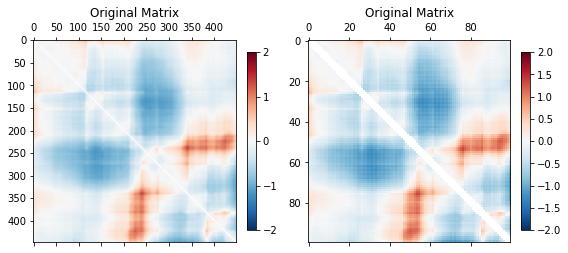

In [106]:
#write separate plotting function so this isn't too messy
#for plotting post akita predictions 


plt.figure(figsize=(8,4))
target_index = 0
vmin=-2; vmax=2

plt.subplot(121) 
im = plt.matshow(test_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05, ticks=[-2,-1, 0, 1,2]);
plt.title('Original Matrix')

plt.subplot(122) 
im = plt.matshow(target_mat, fignum=False, cmap= 'RdBu_r', vmax=vmax, vmin=vmin)
plt.colorbar(im, fraction=.04, pad = 0.05);
plt.title('Original Matrix')
plt.tight_layout()


plt.tight_layout()


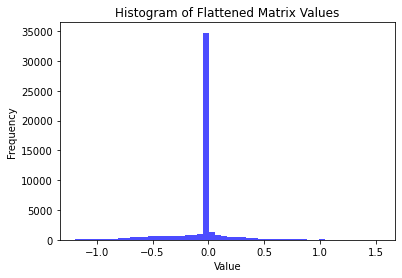

In [19]:
flattened_values = original_matrix1.flatten()

# Plot the histogram
plt.hist(flattened_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Flattened Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [ ]:
flattened_values = target_mat.flatten()

# Plot the histogram
plt.hist(flattened_values, bins=50, color='blue', alpha=0.7)
plt.title('Histogram of Flattened Matrix Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()